# Определение стоимости автомобилей

**Описание исследования**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель исследования**

Нам поручили разработать решение, которое позволит быстро узнать рыночную стоимость автомобиля.

**Задачи исследования**

Нам нужно построить модель для определения стоимости автомобиля. 

**Описание данных** 

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

**Данную задачу разобьем на 3 этапа:**

1. Загрузим и изучим данные. Подготовим выборки для обучения моделей.
2. Обучим разные модели. Для каждой модели попробуем разные гиперпараметры.
3. Проанализируем время обучения, время предсказания и качество моделей. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

!pip install lightgbm -q
from lightgbm import LGBMRegressor

!pip install phik -q
import phik
from phik.report import plot_correlation_matrix

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

Загрузим данные

In [2]:
try:
    auto = pd.read_csv('/datasets/autos.csv', parse_dates=[0, 12, 15]) #обозначим тип даты для 3 столбцов
except:
    auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=[0, 12, 15])

In [3]:
auto_old = auto.shape[0]
auto.info()
auto.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
auto['DateCrawled'].sort_values().unique()

array(['2016-03-05T14:06:22.000000000', '2016-03-05T14:06:23.000000000',
       '2016-03-05T14:06:24.000000000', ...,
       '2016-04-07T14:36:55.000000000', '2016-04-07T14:36:56.000000000',
       '2016-04-07T14:36:58.000000000'], dtype='datetime64[ns]')

Данные были выгружены в период с 2016-03-05 по 2016-04-07.

В данных очень много пропущенных значений, также не все столбцы нам нужны для прогнозирования цены авто.

In [5]:
auto['NumberOfPictures'].unique()

array([0], dtype=int64)

In [6]:
auto['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Для анализа нам не нужны признаки, относящиеся к датам `DateCrawled`, `DateCreated`, `LastSeen`. 

Месяц регистрации автомобиля `RegistrationMonth` имеет нулевые значения и несет мало полезной информации, для прогноза достаточно только года регистрации, поэтому его тоже удаляем. 

Так же значения почтовых индексов владельцев `PostalCode` нам тоже не помогут в анализе. 

Ни для одного объявления не указано количество фотографий автомобиля `NumberOfPictures`, поэтому данный столбец тоже удаляем.

In [7]:
auto = auto.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures'])

In [8]:
auto.info()
auto.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [9]:
auto['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

`gasoline` и `petrol`, эти два слова используются в разных странах, но означают одно и тоже - бензин. Объеденим эти значения в одно `gasoline`

In [10]:
auto['FuelType'] = auto['FuelType'].replace('petrol', 'gasoline')

Заполним пропуски в столбце с ремонтом машины, скорее всего пропуски означают отрицатальный ответ, заменим их на `no`.

In [11]:
auto['Repaired'] = auto['Repaired'].fillna('no')

Автомобиль не может стоить слишком дешево, в любом случае его всегда можно сдать на металлолом. Поэтому ограничим нижнюю границу цены в 200 евро.

In [12]:
auto = auto.query('Price >= 1000')

Ограничимся годом регистрации автомобиля Ford Model T - 1908, и не будем учитывать все автомобили до него.
На основе этой машины сделаем ограничение и по мощности - 20 л.с, а потолок мощности по машине Lotus Evija - 2000 л.с.

In [13]:
auto = auto.query('1908 <= RegistrationYear <= 2016 and 20 <= Power <= 2000')

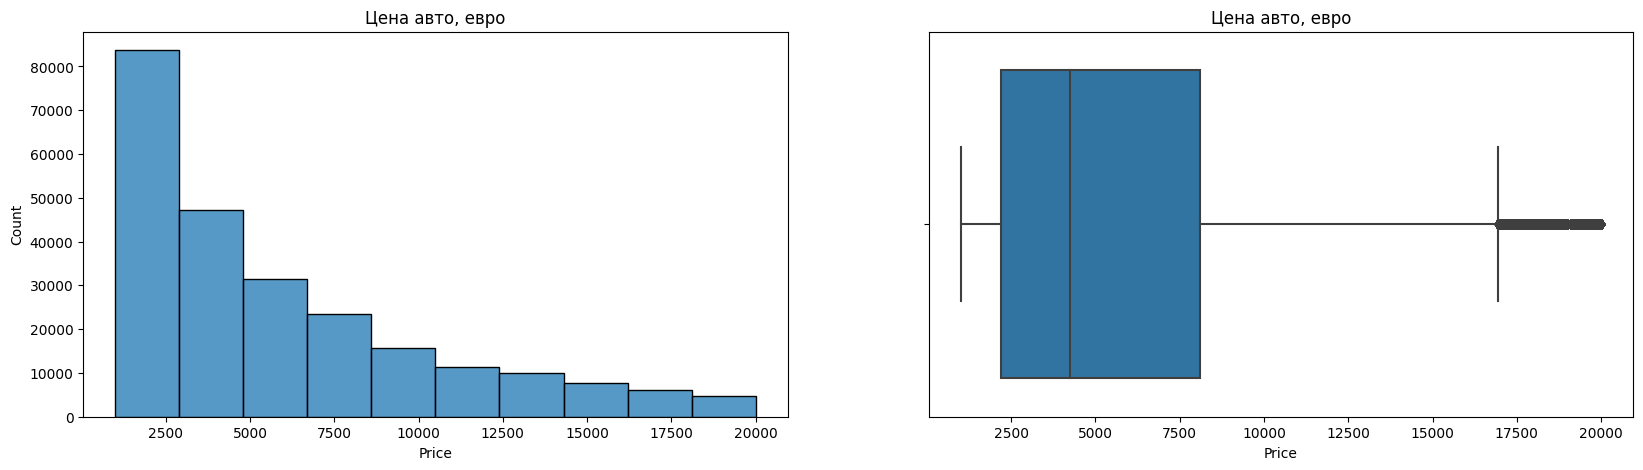

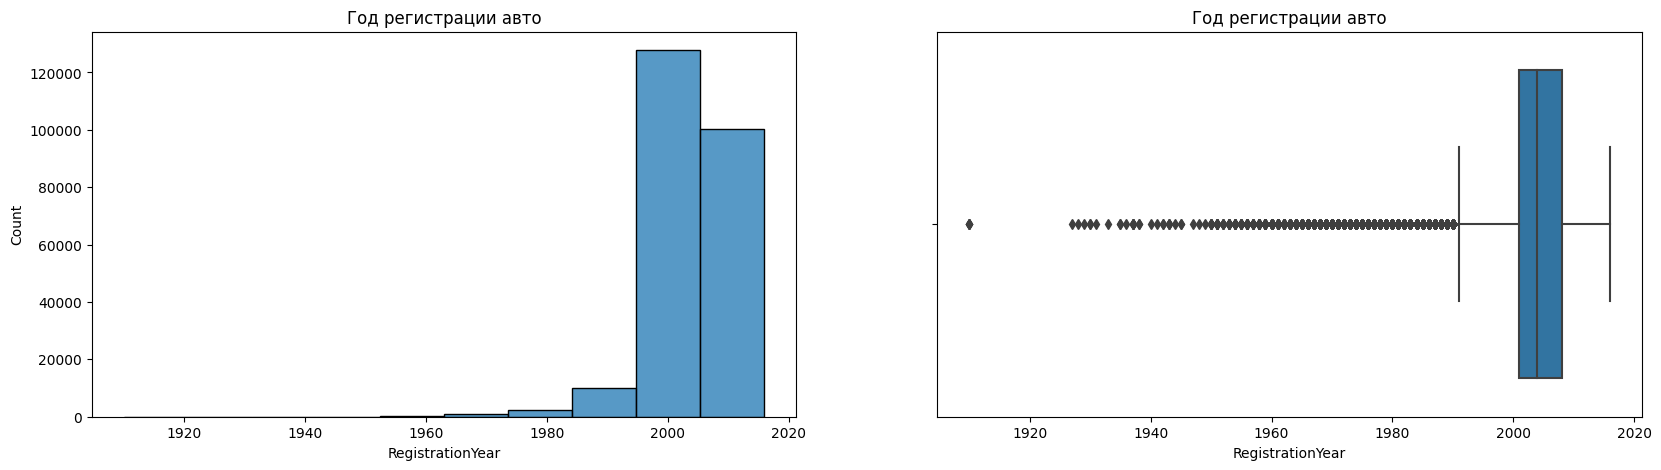

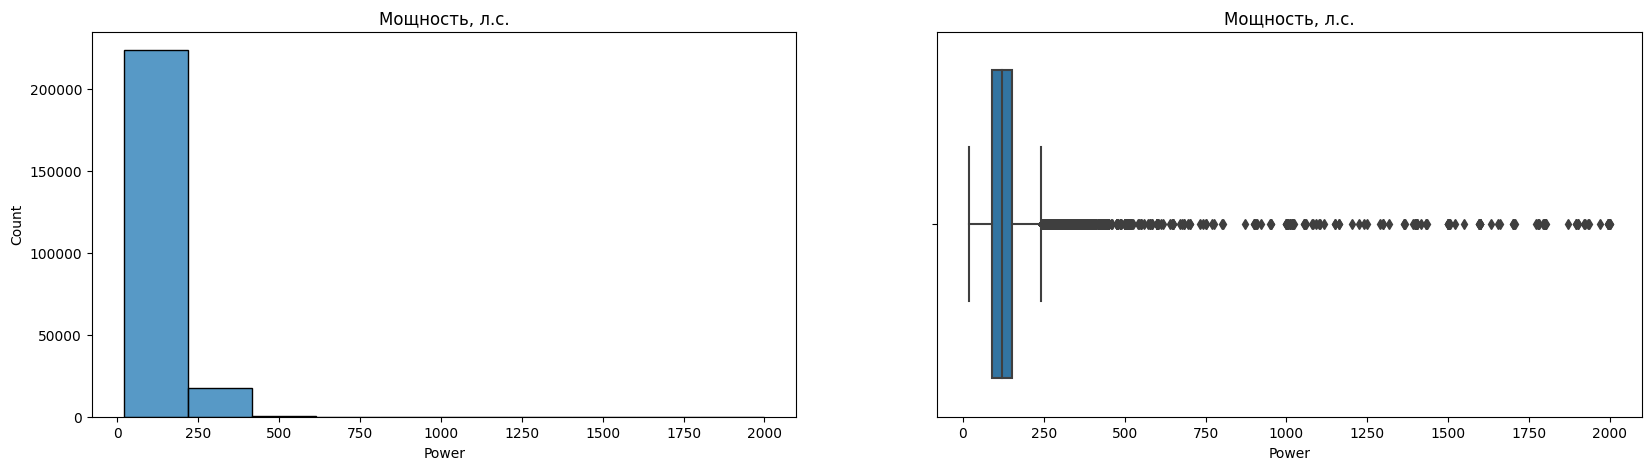

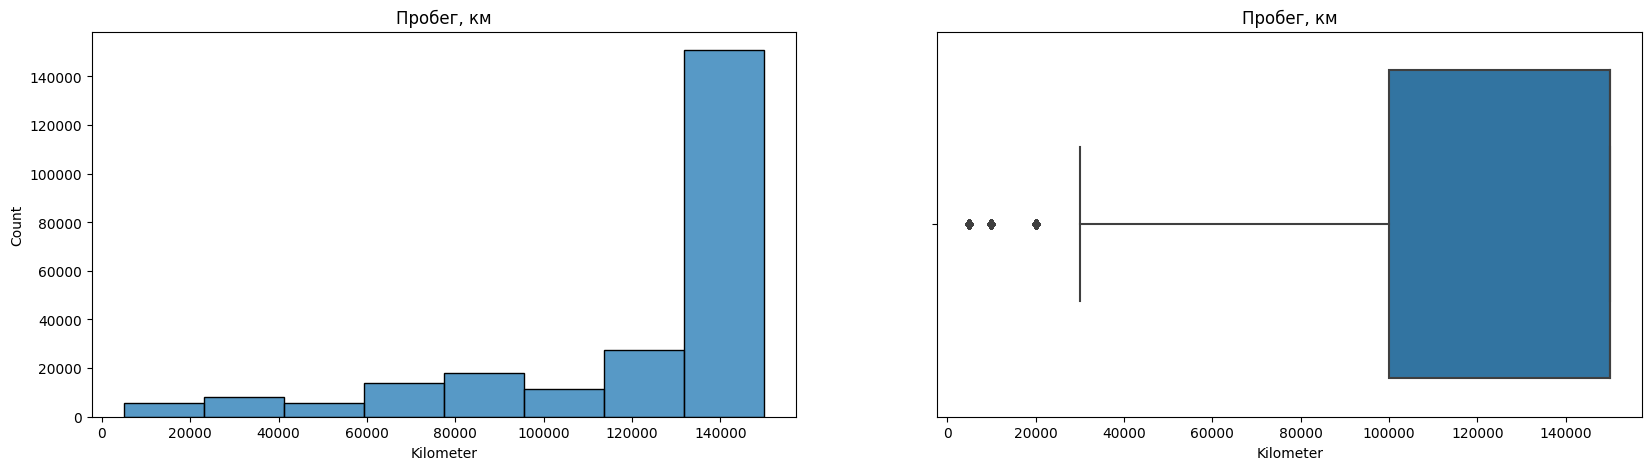

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(auto['Price'], bins=10, ax=axes[0]).set_title('Цена авто, евро')
sns.boxplot(x=auto['Price'], ax=axes[1]).set_title('Цена авто, евро')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(auto['RegistrationYear'], bins=10, ax=axes[0]).set_title('Год регистрации авто')
sns.boxplot(x=auto['RegistrationYear'], ax=axes[1]).set_title('Год регистрации авто')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(auto['Power'], bins=10, ax=axes[0]).set_title('Мощность, л.с.')
sns.boxplot(x=auto['Power'], ax=axes[1]).set_title('Мощность, л.с.')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(auto['Kilometer'], bins=8, ax=axes[0]).set_title('Пробег, км')
sns.boxplot(x=auto['Kilometer'], ax=axes[1]).set_title('Пробег, км');

После наших ограничений данные выглядит нормально. В основном стоимость машин не превышает 7500 евро. Большинство машин были выпущены после 2000 годов. Мощность машин в среднем меньше 250 л.с. Больше всего машины имеют пробег свыше 100 тысяч километров.

In [15]:
phik_overview=auto.phik_matrix(interval_cols=['Price', 'Power']);

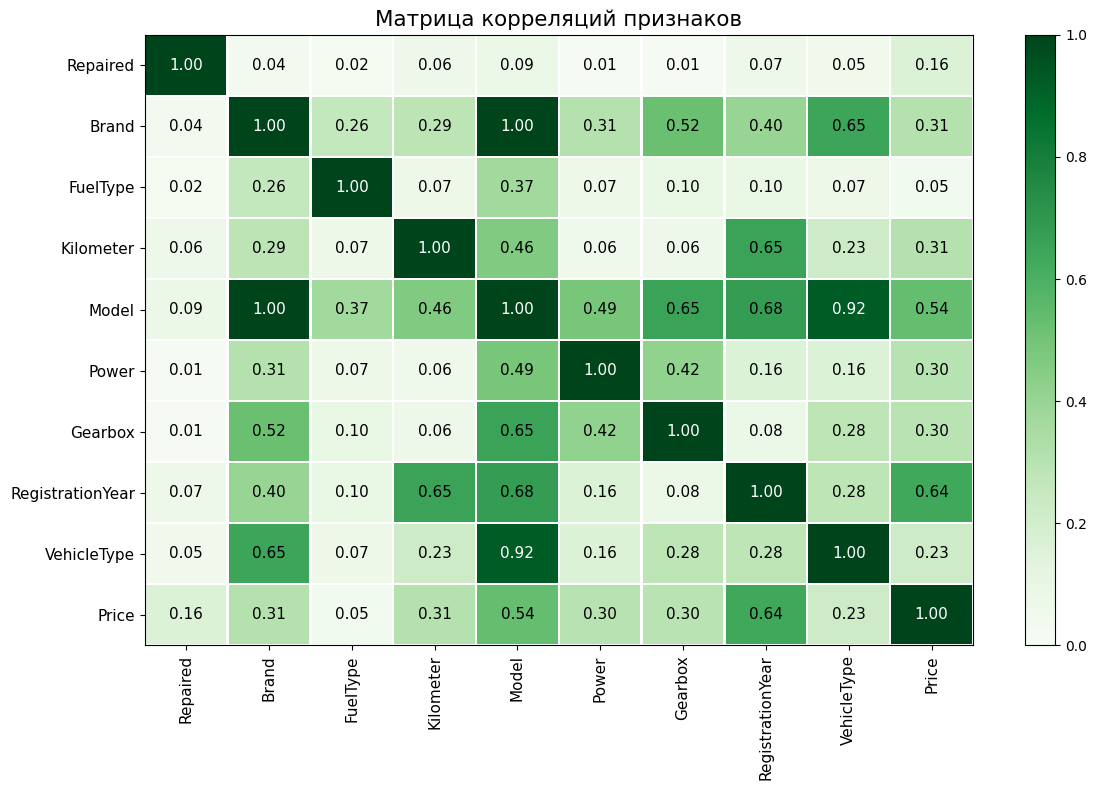

In [16]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Матрица корреляций признаков',
    fontsize_factor=1.1,
    figsize=(12, 8))

Имеем сильную связь между моделью и брендом машины и между моделью и типом кузова.

Видим что больше всего на цену влияет год выпуска авто, что в полне логично. А причиной не столь высокой зависимости являются редкие старые машины которые могут стоить очень дорого.

In [17]:
auto.isnull().sum()

Price                  0
VehicleType         6016
RegistrationYear       0
Gearbox             3533
Power                  0
Model               7632
Kilometer              0
FuelType            9476
Brand                  0
Repaired               0
dtype: int64

Пропущенные значения в столбцах `VehicleType`, `Gearbox`, `FuelType`, `Model` будет сложно заполнить, и оставлять их пустыми нельзя для правильности прогноза. Поэтому создадим новое значение `missing` в которое войдут все пропущенные значения.

In [18]:
auto[['VehicleType', 'Gearbox', 'FuelType', 'Model']] = auto[['VehicleType', 'Gearbox', 'FuelType', 'Model']].fillna('missing')

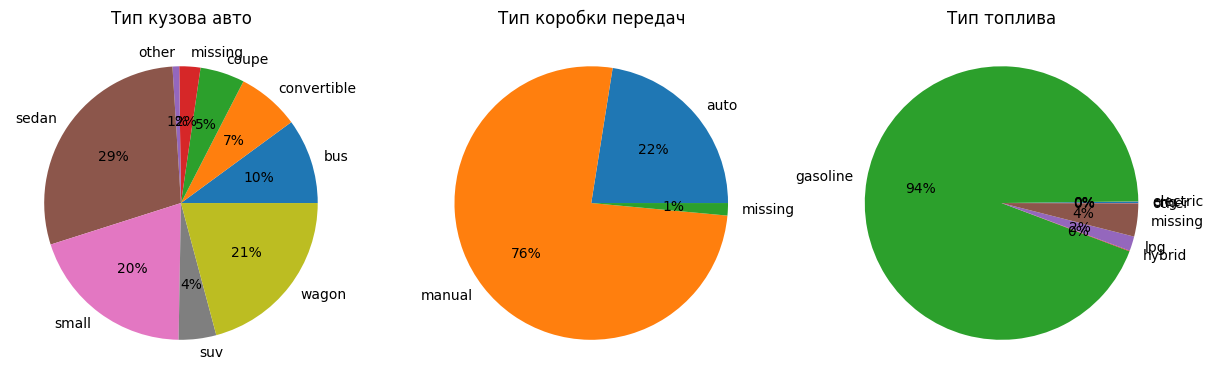

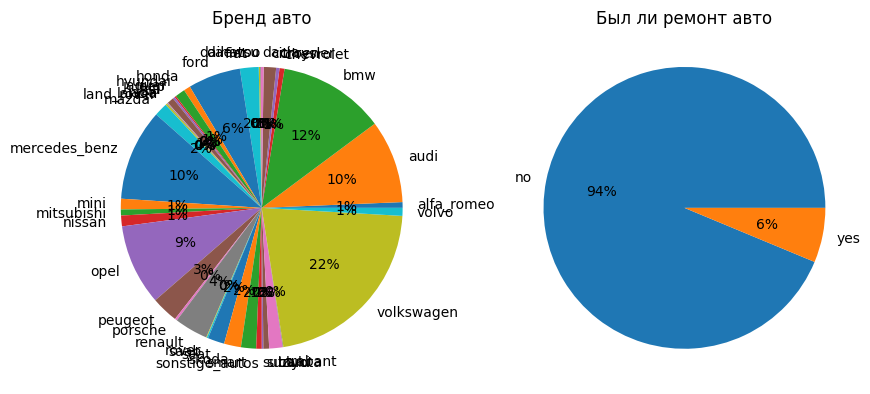

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
auto.pivot_table(index='VehicleType', values='Price', aggfunc='count').plot(
    kind='pie', y='Price', legend=False, autopct = '%1.0f%%', 
    title = 'Тип кузова авто', ylabel='', ax=axes[0])

auto.pivot_table(index='Gearbox', values='Price', aggfunc='count').plot(
    kind='pie', y='Price', legend=False, autopct = '%1.0f%%', 
    title = 'Тип коробки передач', ylabel='', ax=axes[1])

auto.pivot_table(index='FuelType', values='Price', aggfunc='count').plot(
    kind='pie', y='Price', legend=False, autopct = '%1.0f%%', 
    title = 'Тип топлива', ylabel='', ax=axes[2])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
auto.pivot_table(index='Brand', values='Price', aggfunc='count').plot(
    kind='pie', y='Price', legend=False, autopct = '%1.0f%%', 
    title = 'Бренд авто', ylabel='', ax=axes[0])

auto.pivot_table(index='Repaired', values='Price', aggfunc='count').plot(
    kind='pie', y='Price', legend=False, autopct = '%1.0f%%', 
    title = 'Был ли ремонт авто', ylabel='', ax=axes[1]);

Почти все авто ездят на бензине - 94%, и большинство из них на механике - 76%. Выделяются 3 популярные кузова - sedan, small и wagon. Из брендов можно выделить - volkswagen, bmw, opel, mercedes, audi, ford. Только 6% авто были в ремонте, либо продавцы просто умалчивают об этом при продаже.

In [20]:
auto_clear = auto.shape[0]

In [21]:
round(100 - (auto_clear / auto_old)*100, 1)

31.9

Мы удалили из наших данных 31.9% информации. Перейдем теперь к подготовке выборки для обучения моделей.

In [22]:
X = auto.drop(['Price'], axis=1)
y = auto['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

cat_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear', 'Kilometer', 'Model']
num_columns = ['Power']

## Обучение моделей

Обучим две разные модели, одна из которых — LGBMRegressor, другая — DecisionTreeRegressor. Для каждой модели подберем разные гиперпараметры. Для оценки качества моделей будем применять метрику RMSE, значение метрики должно быть меньше 2500.

In [23]:
data_preprocessor = ColumnTransformer(
    [('ord', OrdinalEncoder(handle_unknown='ignore'), cat_columns),
     ('num', StandardScaler(), num_columns)],
    remainder='passthrough')

In [24]:
pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LGBMRegressor(random_state=RANDOM_STATE))])

In [25]:
param_distributions = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
        'models__n_estimators': range(200,210),
        'models__max_depth': range(2, 6)
    },
    { 
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(2,6), 
        'models__min_samples_split' : range(1,10)
    }
] 

In [26]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [27]:
randomized_search.fit(X_train, y_train);

In [28]:
print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_) 

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика RMSE для лучшей модели: {abs(randomized_search.best_score_)}')

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand',
                                                   'Repaired',
                                                   'RegistrationYear',
                                                   'Kilometer', 'Model']),
                                                 ('num', StandardScaler(),
                                                  ['Power'])])),
                ('models',
                 LGBMRegressor(max_depth=5, n_estimators=205, random_state=42,
                               verbose=-1))])
Метрика RMSE для лучшей модели: 1758.4502965654658


Лучшей моделью стала LGBMRegressor с параметрами max_depth=5, n_estimators=205. Метрика имеет хорошее значение, но нужно сравнить ее с другой моделью DecisionTreeRegressor.

## Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей. Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

In [29]:
cv_results = pd.DataFrame(randomized_search.cv_results_)[['mean_test_score', 'mean_fit_time','mean_score_time', 'param_models', 'params']]

In [30]:
cv_results['mean_test_score'] = cv_results['mean_test_score'] *(-1)

In [31]:
cv_results.sort_values(by='mean_test_score')

,mean_test_score,mean_fit_time,mean_score_time,param_models,params
1,1758.450297,12.756084,0.223402,"LGBMRegressor(max_depth=5, n_estimators=205, r...","{'models__n_estimators': 205, 'models__max_dep..."
9,1818.287802,3.056625,0.221009,"LGBMRegressor(max_depth=5, n_estimators=205, r...","{'models__n_estimators': 208, 'models__max_dep..."
2,1917.201410,3.472912,0.166355,"LGBMRegressor(max_depth=5, n_estimators=205, r...","{'models__n_estimators': 200, 'models__max_dep..."
0,2034.214003,2.460619,0.254719,"LGBMRegressor(max_depth=5, n_estimators=205, r...","{'models__n_estimators': 204, 'models__max_dep..."
3,2037.148579,3.567060,0.146009,"LGBMRegressor(max_depth=5, n_estimators=205, r...","{'models__n_estimators': 200, 'models__max_dep..."
6,2733.355093,0.714290,0.121076,DecisionTreeRegressor(random_state=42),"{'models__min_samples_split': 8, 'models__max_..."
7,3035.159953,0.685566,0.124268,DecisionTreeRegressor(random_state=42),"{'models__min_samples_split': 5, 'models__max_..."
8,3035.159953,0.810433,0.138829,DecisionTreeRegressor(random_state=42),"{'models__min_samples_split': 2, 'models__max_..."
4,3291.575533,0.524597,0.101728,DecisionTreeRegressor(random_state=42),"{'models__min_samples_split': 6, 'models__max_..."
5,3291.575533,0.618147,0.119480,DecisionTreeRegressor(random_state=42),"{'models__min_samples_split': 8, 'models__max_..."


LGBMRegressor обучается более 3 секунд, когда DecisionTreeRegressor менее чем за 1 секунду. Время предсказания имеет такое же различие, LGBMRegressor предсказывает чуть дольше, чем DecisionTreeRegressor. При этом значения метрики у LGBMR лучше. Метрики для DecisionTreeRegressor не соответсвуют критерию заказчику > 2500.

Поэтому лучшей метрикой для заказчика остается LGBMRegressor с параметрами max_depth=5, n_estimators=205.

In [32]:
cv_results['param_models'] = cv_results['param_models'].astype('category')

In [33]:
lgbmr = cv_results.groupby('param_models')['mean_test_score'].min()[0]
tree = cv_results.groupby('param_models')['mean_test_score'].min()[1]

In [34]:
pd.concat([cv_results.query('mean_test_score == @lgbmr'),cv_results.query('mean_test_score == @tree')])

,mean_test_score,mean_fit_time,mean_score_time,param_models,params
1,1758.450297,12.756084,0.223402,"LGBMRegressor(max_depth=5, n_estimators=205, r...","{'models__n_estimators': 205, 'models__max_dep..."
6,2733.355093,0.714290,0.121076,DecisionTreeRegressor(random_state=42),"{'models__min_samples_split': 8, 'models__max_..."


In [35]:
pipe_lgbmr = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LGBMRegressor(max_depth=5, n_estimators=205, random_state=42, verbose=-1))])

In [36]:
pipe_lgbmr.fit(X_train, y_train)
y_test_pr = pipe_lgbmr.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pr, squared=False)}')

Метрика RMSE на тестовой выборке: 1747.2040566000996


На тестовой выборке получен также хороший результат.

Итоговой моделью для заказчика выбираем LGBMRegressor с параметрами max_depth=5, n_estimators=205.

In [37]:
pipe_dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyRegressor())])

pipe_dummy.fit(X_train, y_train) 

dummy_pred = pipe_dummy.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, dummy_pred, squared=False)}') 

Метрика RMSE на тестовой выборке: 4563.967198502209


Проверили результат метрики на константной моделе. Видим что результат метрики найденной модели гораздо лучше, чем результат константной модели.

## Общий вывод

Полученные нами данные были выгружены в период с 2016-03-05 по 2016-04-07.

В ходе обработки данных мы:
- Избавились от неинформативных столбцов DateCrawled, DateCreated, LastSeen, RegistrationMonth, PostalCode, NumberOfPictures
- Объединили значения gasoline и petrol в типе топлива
- Заполнили пропуски в столбце с ремонтом машины Repaired, заменили их на no.
- Ограничили цену авто от 1000 евро
- Ограничили года выпуска с 1908 по 2016 года, мощности от 20 до 2000 л.с.
- Избавились от пропущенных значений в столбцах VehicleType, Gearbox, FuelType, Model путем создания нового значения missing.

По итогу обработки мы удалили из наших данных 31.9% строк с пропущенными значениями.

В ходе анализа данных мы получили, что:
- В основном стоимость машин не превышает 7500 евро. Большинство машин были выпущены после 2000 годов. Мощность машин в среднем меньше 250 л.с. Больше всего машины имеют пробег свыше 100 тысяч километров.
- Имеем сильную связь между моделью и брендом машины и между моделью и типом кузова.
- Больше всего на цену влияет год выпуска авто.
- Почти все авто ездят на бензине - 94%, и большинство из них на механике - 76%. Выделяются 3 популярные кузова - sedan, small и wagon. Из брендов можно выделить - volkswagen, bmw, opel, mercedes, audi, ford. Только 6% авто были в ремонте, либо продавцы просто умалчивают об этом при продаже.

Мы обучали две разные модели, LGBMRegressor и DecisionTreeRegressor. Для каждой модели подбирали разные гиперпараметры. Для оценки качества моделей использовали метрику RMSE, значение которой не должно было превышать 2500.

Лучшей по качеству метрики стала модель LGBMRegressor с параметрами max_depth=5, n_estimators=205, со значением RMSE для 1758.

В ходе анализа времени обучения и предсказания, а также качества моделей, мы получили:
- LGBMRegressor обучается более 3 секунд, делает прогноз за 0.2 секунды. Лучшая метрика 1758.
- DecisionTreeRegressor обучается менее 1 секунды, делает прогноз за 0.1 секунды. Лучшая метрика 2733.

DecisionTreeRegressor не соответсвует критерию заказчика по качеству метрики, она превышает 2500. Поэтому лучшей метрикой для заказчика выбрали LGBMRegressor с параметрами max_depth=5, n_estimators=205.

Метрика RMSE для выбранной модели на тестовой выборке показала хороший результат - 1747.
Проверка результата метрики на константной модели подтвердила правильность нашего решения: полученная метрика гораздо лучше, чем метрика константной модели - 4563.

Выбранная модель имеет хорошее время прогнозирования, клиенты точно будут довольны скоростью работы приложения. И при этом метрика имеет гораздо лучшее значение, чем требовал заказчик.
Рекомендацией для моих коллег можно посоветовать рассмотреть другие модели.